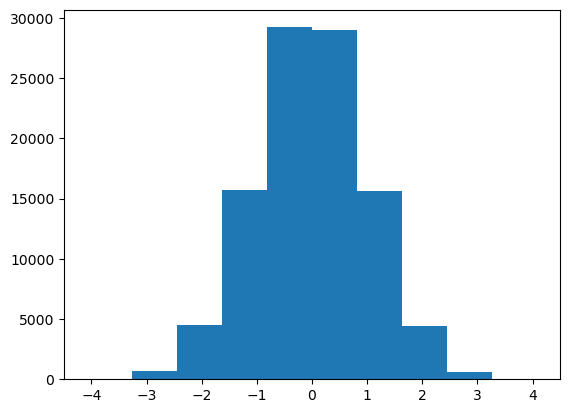

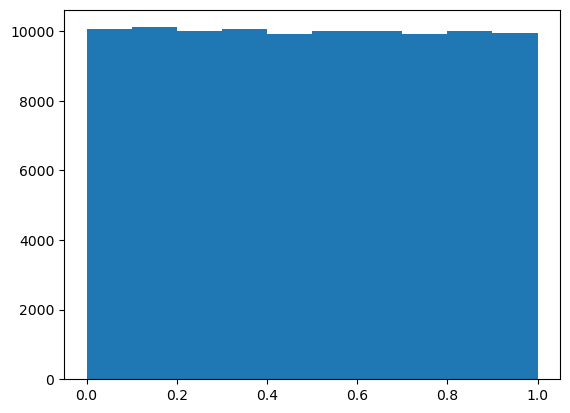

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

normal_samples = np.random.normal(size = 100000) # 生成 100000 組標準常態分配（平均值為 0，標準差為 1 的常態分配）隨機變數
uniform_samples = np.random.uniform(size = 100000) # 生成 100000 組介於 0 與 1 之間均勻分配隨機變數

plt.hist(normal_samples)
plt.show()
plt.hist(uniform_samples)
plt.show()

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

from PIL import Image, ImageOps

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
resize = 200
batch_size = 64
data_dir = 'data'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize),
        transforms.RandomResizedCrop(resize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'validation', 'test']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=batch_size,
                             shuffle=(x == 'train'),
                             num_workers=4)
               for x in ['train', 'validation', 'test']}

class_names = dataloaders["test"].dataset.classes

In [5]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*200*200, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#optimizer = torch.optim.RMSprop(model.parameters(), 0.01, alpha=0.9)
#optimizer = torch.optim.Adam(model.parameters(), 0.01, betas=(0.9, 0.99))

NeuralNetwork(
  (fc1): Linear(in_features=120000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
)


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.flatten(start_dim=1)
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X) #len(X) = batch_size 64
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size

    train_losses.append(train_loss)
    train_acc.append(correct)

    # writer.add_scalar('Loss/Train', train_loss, t)
    # writer.add_scalar('Accuracy/Train', correct, t)

    writer.add_scalars(main_tag='Loss', tag_scalar_dict={'Train Loss': train_loss}, global_step=t)
    writer.add_scalars(main_tag='Accuracy', tag_scalar_dict={'Train Accuracy': correct}, global_step=t)

    print(f"train accuracy:\t\t{(100*correct):>0.1f}%, train loss:\t\t{train_loss:>4f}")


def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()

    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.flatten(start_dim=1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            
            validation_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= size
    correct /= size

    validation_losses.append(validation_loss)
    validation_acc.append(correct)

    # writer.add_scalar('Loss/Test', test_loss, t)
    # writer.add_scalar('Accuracy/Test', correct, t)

    writer.add_scalars(main_tag='Loss', tag_scalar_dict={'Validation Loss': validation_loss}, global_step=t)
    writer.add_scalars(main_tag='Accuracy', tag_scalar_dict={'Validation Accuracy': correct}, global_step=t)

    print(f"validation accuracy:\t{(100*correct):>0.1f}%, validation loss:\t\t{validation_loss:>4f}")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.flatten(start_dim=1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size

    print(f"test accuracy:\t\t{(100*correct):>0.1f}%, test loss:\t\t{test_loss:>4f}")


def test_with_confusion(dataloader, model, loss_fn, class_names):
    size = len(dataloader.dataset)
    model.eval()

    test_loss, correct = 0, 0
    all_preds = []
    all_y = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.flatten(start_dim=1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_y.extend(y.cpu().numpy())

    test_loss /= size
    correct /= size

    # 計算混淆矩陣
    cm = confusion_matrix(all_y, all_preds)

    # 繪製熱力圖
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return correct, test_loss, cm


def show_misclassified_images(dataloader, model, class_names, max_images=10):

    model.to(device)
    model.eval()

    misclassified_images = []
    y_labels = []
    pred_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.flatten(start_dim=1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            predict = pred.argmax(1)

            for img, label, predict_class in zip(X, y, predict):
                if label != predict_class:  
                    img = img.reshape(3, resize, resize)
                    misclassified_images.append(img.cpu())
                    y_labels.append(class_names[label.item()])
                    pred_labels.append(class_names[predict_class.item()])

                if len(misclassified_images) >= max_images:
                    break
            if len(misclassified_images) >= max_images:
                break

    plt.figure(figsize=(12, 6))
    for i in range(len(misclassified_images)):
        plt.subplot(2, (max_images+1)//2, i+1)
        img = misclassified_images[i].permute(1, 2, 0)  # [C,H,W] → [H,W,C]
        img = (img * 0.5 + 0.5).clamp(0,1)  # 還原 Normalize
        plt.imshow(img)
        plt.title(f"label: {y_labels[i]}\npredict: {pred_labels[i]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


def predict_image(path, model, class_names):
   
    model.to(device)
    model.eval()

    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        image = image.flatten(start_dim=1)
        pred = model(image)
        predict = pred.argmax(1).cpu().numpy()
    predict_class = class_names[predict.item()]
    
    return predict_class

In [8]:
acc_loss_dir = 'runs/acc_loss'
epochs = 300
train_losses = []
train_acc = []
validation_losses = []
validation_acc = []
writer = SummaryWriter(acc_loss_dir)
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train(dataloaders["train"], model, loss_fn, optimizer)
    validation(dataloaders["validation"], model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 1.107892  [   64/  750]
loss: 0.999439  [  704/  750]
train accuracy:		54.8%, train loss:		0.016171
validation accuracy:	53.3%, validation loss:		0.020799

Epoch 2
-------------------------------
loss: 0.909044  [   64/  750]
loss: 0.931949  [  704/  750]
train accuracy:		61.7%, train loss:		0.015005
validation accuracy:	57.3%, validation loss:		0.020559

Epoch 3
-------------------------------
loss: 0.938502  [   64/  750]
loss: 0.785648  [  704/  750]
train accuracy:		66.0%, train loss:		0.014417
validation accuracy:	59.3%, validation loss:		0.020255

Epoch 4
-------------------------------
loss: 0.879561  [   64/  750]
loss: 0.914857  [  704/  750]
train accuracy:		66.8%, train loss:		0.014105
validation accuracy:	60.0%, validation loss:		0.019960

Epoch 5
-------------------------------
loss: 0.880022  [   64/  750]
loss: 0.912155  [  704/  750]
train accuracy:		68.9%, train loss:		0.013530
validation accuracy:	58.7%, validation loss:	

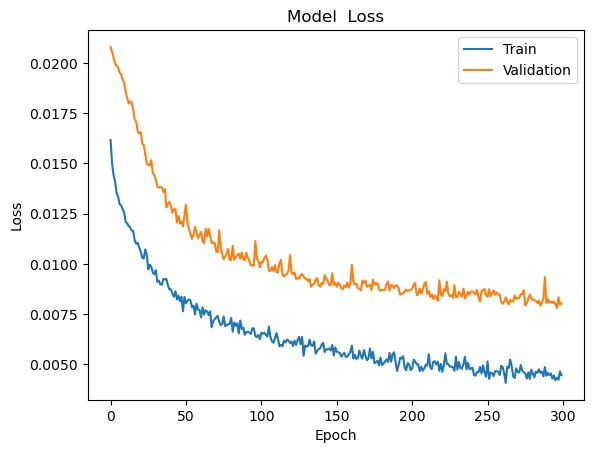

In [9]:
plt.plot(np.arange(0,epochs),train_losses)
plt.plot(np.arange(0,epochs),validation_losses)
plt.title('Model  Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

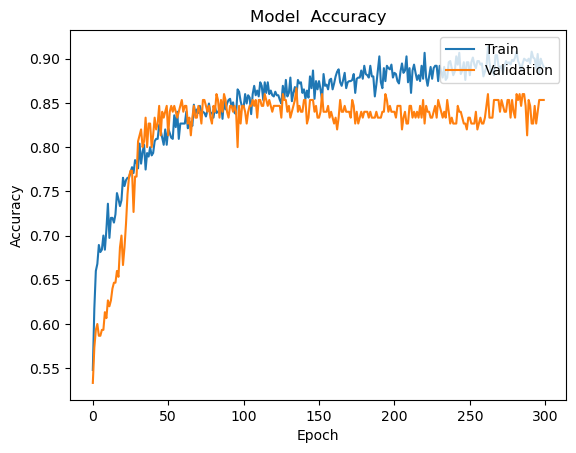

In [10]:
plt.plot(np.arange(0,epochs),train_acc)
plt.plot(np.arange(0,epochs),validation_acc)
plt.title('Model  Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [11]:
test(dataloaders["test"], model, loss_fn)

test accuracy:		85.3%, test loss:		0.008025


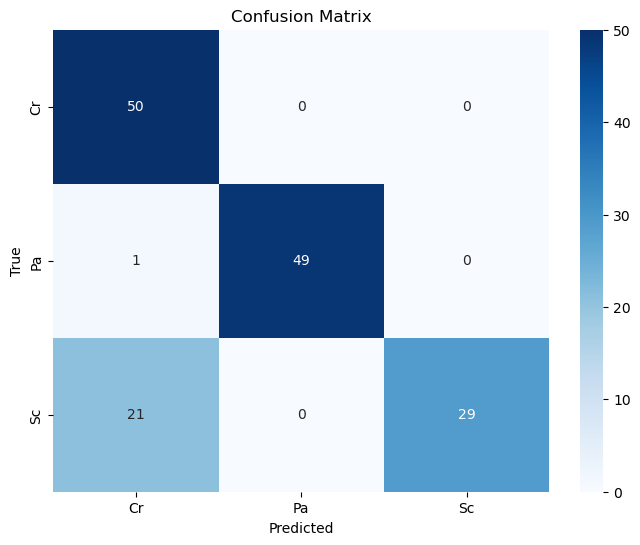

test accuracy: 85.3%, test loss: 0.008025
Confusion Matrix:
 [[50  0  0]
 [ 1 49  0]
 [21  0 29]]


In [12]:
test_acc, test_loss, cm = test_with_confusion(dataloaders["test"], model, loss_fn, class_names)
print(f"test accuracy: {(100*test_acc):>0.1f}%, test loss: {test_loss:>4f}")
print("Confusion Matrix:\n", cm)

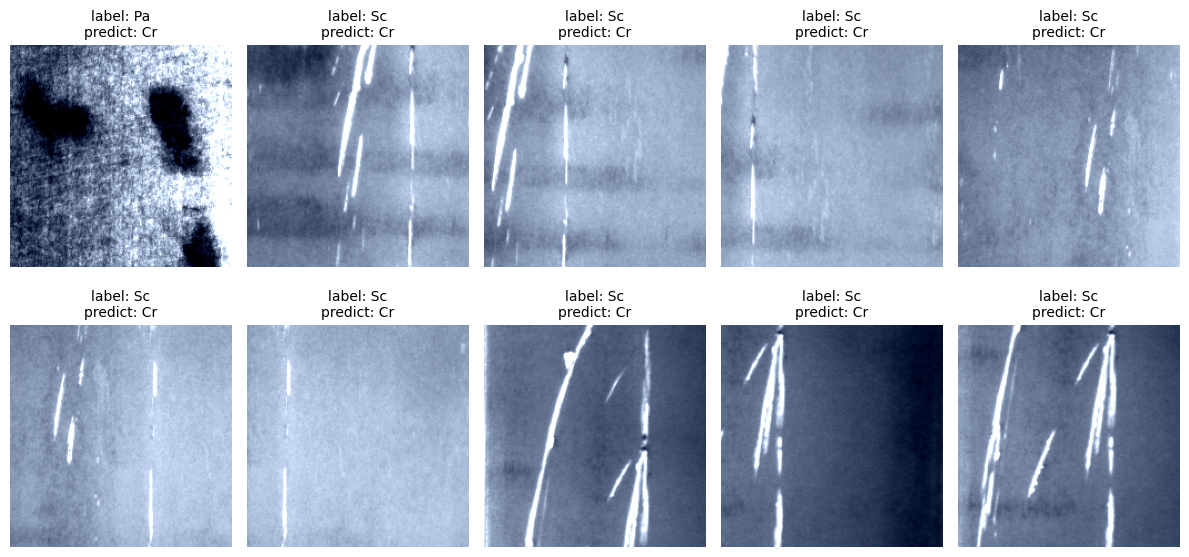

In [13]:
show_misclassified_images(dataloaders["test"], model, class_names, max_images=10)

In [14]:
path = r"data\test\Sc\Sc_1.bmp"
predict_class = predict_image(path, model, class_names)
print(f"The predicted classification is {predict_class}")

The predicted classification is Sc


In [15]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

In [16]:
torch.save(model, 'model.pth')

In [17]:
model = torch.load('model.pth', weights_only=False)